# IMPORTS

In [1]:
import warnings
warnings.filterwarnings("ignore")
import collections
import xlrd
from time import sleep
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import pyarrow.parquet as pq
import pyarrow.csv as csv
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import timeit
import os,pickle, sys, json
import time
from sklearn.linear_model import LinearRegression
import pickle
from datetime import datetime, timedelta
import openpyxl
from openpyxl import load_workbook
import itertools
from multiprocessing import Pool
import multiprocessing
processors = multiprocessing.cpu_count()
from functools import partial
from tqdm import tqdm
from difflib import SequenceMatcher
pd.options.display.max_columns = None

# USER-DEFINED FUNCTIONS

In [2]:
def corr_compare_df(df1,df2):
    list_ = []
    for col1 in tqdm(df1.columns):
        col1_ = ''
        col2_ = ''
        corr_val1 = -10000
        for col2 in df2.columns:
            try:
                corr_val = df2[col1].corr(df2[col2])
                if corr_val > corr_val1:
                    corr_val1 = corr_val
                    col1_ = col1
                    col2_ = col2
            except:
                pass
        if corr_val1 > 0.9:
            list_.append([col1_,col2_,corr_val1])
    return list_


def check_column_names(var1,var2,df1,df2,threshold=0.7):
    print("check_column_names")
    from difflib import SequenceMatcher
    list_ = []
    similar_cols_by_names_list = []
    similar_cols_by_names_df = pd.DataFrame(columns = ['Table1','Table2','Table1_column','Table2_column','Criteria_Type','Criteria_Value'])
    for col1 in df1.columns:
        for col2 in df2.columns:
            similarity_value = SequenceMatcher(None, col1.lower(), col2.lower()).ratio()
            if similarity_value > threshold:
                list_.append([var1,var2,col1,col2,"By_Common_name",similarity_value])
                
    ## CHANGE
    if len(list_) > 0:
        similar_cols_by_names_df = pd.DataFrame(data=list_,columns=['Table1','Table2','Table1_column','Table2_column','Criteria_Type','Criteria_Value'])
        similar_cols_by_names_list = list(similar_cols_by_names_df['Table1_column']) + list(similar_cols_by_names_df['Table2_column'])
        return similar_cols_by_names_df, similar_cols_by_names_list
    else:
        return pd.DataFrame(), []
    ## CHANGE



def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()


def possible_dummy_cols(df):
    index_cols = []
    for col in df.select_dtypes(include=np.number).columns:
        elements = np.array(df[col])
        for i in range(len(elements)-1):
            prev_ = elements[i]
            next_ = elements[i+1]
            if i>0:
                c_diff = next_- prev_
                step1 = c_diff - p_diff
                if c_diff*p_diff < 0 or step0 != step1:
                    # print('{}: Not a Index column'.format(col))
                    break
                else:
                    p_diff = c_diff
                    step0 = step1
            else:
                c_diff = next_- prev_
                p_diff = c_diff
                step0 = c_diff - p_diff
        if i+1 == len(elements)-1:
            index_cols.append(col)
    return index_cols


def correct_dtypes_func(df,var):
    ser = df[var].dropna()
    prev_d = df[var].dtype
    try:
        if df[var].dtype not in ['float64', 'int64', 'datetime64[ns]']:
            if ser[0].isalnum() or ser[0].isalpha():
                df[var] = df[var].astype('category')
            else:
                try:
                    df[var] = pd.to_numeric(df[var])
                except:
                    df[var] = df[var].astype('category')
                    pass
        next_d = df[var].dtype
    except KeyError:
        pass
    

def correct_dtypes_m(df):
    dtypes_ = []
    df = df[df[df.columns[0]] != df.columns[0]]
    with Pool(processes=processors) as pool:
        func = partial(correct_dtypes_func,df)
        pool.map(func, df.columns)
        pool.close()
        pool.join()
    df.replace('NULL_VAL', np.nan, inplace=True)
    dtypes_df = pd.DataFrame()
    return df, dtypes_df

def correct_dtypes(df):
    dtypes_ = []
    df = df[df[df.columns[0]] != df.columns[0]]
    for var in df.columns:
        ser = df[var].dropna()
        prev_d = df[var].dtype
        try:
            if df[var].dtype not in ['float64', 'int64', 'datetime64[ns]', 'bool']:
#                 try:
                if ser[0].isalnum() or ser[0].isalpha():
                    df[var] = df[var].astype('category')
                else:
                    try:
                        df[var] = pd.to_numeric(df[var])
                    except:
                        df[var] = df[var].astype('category')
                        pass
#                 except:
#                     print(ser[0], type(ser[0]), var, df[var].dtype)
            next_d = df[var].dtype
            dtypes_.append([var,prev_d,next_d])
        except KeyError:
            pass
    df.replace('NULL_VAL', np.nan, inplace=True)
    dtypes_df = pd.DataFrame(data = dtypes_, columns = ['column','prev_dtype','converted_dtype'])
    return df, dtypes_df


def get_summary(df):
    data_summary = []
    for col in df.columns:
        nUnique = 0
        min_val,mean_val,median_val,max_val = np.nan,np.nan,np.nan,np.nan
        min_date, max_date = np.nan,np.nan
        type_ = df[col].dtype
        if df[col].dtype in ['float64','int64']:
            min_val = df[col].min()
            mean_val = df[col].mean()
            median_val = df[col].median()
            max_val = df[col].max()
        elif df[col].dtype == 'datetime64[ns]':
            min_date = df[col].min()
            max_date = df[col].max()
        elif df[col].dtype.name == 'category':
            nUnique = df[col].dropna().nunique()
        data_summary.append([col,type_,nUnique,min_val,mean_val,median_val,max_val,min_date, max_date])

    column=['Column','dtype', 'nUnique','min','mean','median','max','min_date', 'max_date']
    data_summary = pd.DataFrame(data = data_summary, columns=column)
    data_summary = data_summary.T.reset_index()
    data_summary.columns = data_summary.loc[0].values
    data_summary = data_summary.iloc[1:].reset_index(drop=True)
    return data_summary

def get_nunique_dtype(df):
    unique_df = pd.DataFrame(df.nunique()).reset_index()
    unique_df.columns = ['Columns','nUnique']
    dtype_df = pd.DataFrame(df.dtypes).reset_index()
    dtype_df.columns = ['Columns','dtype']
    dtype_df = pd.merge(unique_df, dtype_df, on='Columns', how='inner')
    return dtype_df

def custom_summary_insight(df_name):
    df = globals()[df_name]
    likely_cat = {}
    for col in globals()[df_name].columns:
        col_vals = globals()[df_name][col]
        likely_cat[col] = 1.*col_vals.nunique()/col_vals.count() < 0.01 #or some other threshold
        column_type = globals()[df_name][col].dtype
        if globals()[df_name][col].dtype in ['datetime64[ns]']:
            likely_cat[col] = False
    likely_cat = [[k,likely_cat[k]] for k in likely_cat]
    likely_cat_df = pd.DataFrame(likely_cat, columns = ['Columns', 'Likely_Category'])
    likely_cat_df = pd.merge(get_nunique_dtype(df), likely_cat_df, on = 'Columns', how='inner')
    data_summary = get_summary(df)
    return data_summary,likely_cat_df

def get_date_format(sample_string, show = 0):
    from pydateinfer import infer
    date_time_format = infer([sample_string])
    if show:
        old_date_time_format = date_time_format
    if '%I' in date_time_format and '%p' not in date_time_format.lower():
        date_time_format = date_time_format.replace('%I', '%H')
    return date_time_format

def check_convert_datetime(df, show = 0):
    for col in df.columns:
        try:
            if df[col].dtype == 'category':
                alpha_nums = []
                string_value = df[col].iloc[0]
                for ele in string_value:
                    if ele.isnumeric():
                        alpha_nums.append(1)
                    elif ele.isalpha():
                        if ele.lower() not in ['a', 'p', 'm']:
                            alpha_nums.append(0)
                    else:
                        alpha_nums.append(2)
                if 0 in alpha_nums:
                    continue_ = 0
                    #print('All elements are not Numeric')
                else:
                    continue_ = 1
                    #print('All elements are Numeric')

                from collections import Counter
                counter = Counter(alpha_nums)

                if continue_ == 1 and counter[1] > 4 and counter[2] > 0:
                    continue_ = 1
                else:
                    continue_ = 0

                if continue_:
                    datetime_format = get_date_format(df[col].iloc[0])
                    try:
                        df[col] = pd.to_datetime(df[col], format = datetime_format)
                        df[col] = df[col].astype('datetime64[ns]')
                        print("{} : Converted with ({}) format".format(col, datetime_format))
                    except Exception as e:
                        error = str(e)
                        print(col,e)
                        try:
                            datetime_format = datetime_format.replace('m','z')
                            datetime_format = datetime_format.replace('d','m')
                            datetime_format = datetime_format.replace('z','d')
                            df[col] = pd.to_datetime(df[col], format = datetime_format)
                            df[col] = df[col].astype('datetime64[ns]')
                            print("{} : Converted with ({}) format".format(col, datetime_format))
                        except Exception as e1:
                            error1 = str(e1)
                            print(error1)
                            continue
                        continue
        except:
            continue
    return df

def match_dates(var1,var2,df1,df2, matching_keys_df):
    print("match_dates")
    list_ = []
    df1_cols = [col for col in df1.columns if df1[col].dtype in ['datetime64[ns]']]
    df2_cols = [col for col in df2.columns if df2[col].dtype in ['datetime64[ns]']]
    for col1 in df1_cols:
        for col2 in df2_cols:
            if df1[col1].min() <= df2[col2].min():
                if df2[col2].min() <= df1[col1].max():
                    list_.append([var1,var2,col1,col2,'By_Timeline',np.nan])
            else:
                if df1[col1].min() <= df2[col2].max():
                    list_.append([var1,var2,col1,col2,'By_Timeline',np.nan])
    if len(list_) > 0:
        temp_df = pd.DataFrame(data = list_, columns = ['Table1','Table2','Table1_column','Table2_column','Criteria_Type','Criteria_Value'])
    else:
        temp_df = pd.DataFrame()
    return pd.concat([matching_keys_df, temp_df])

def corrected_df_and_summary(df_name):
    globals()[df_name], dtypes_summary_df = correct_dtypes(globals()[df_name])
    df = globals()[df_name]
    dummy_cols = possible_dummy_cols(df)
    globals()[df_name] = check_convert_datetime(df, 1)
#     check_convert_datetime(globals()[df_name], 1)
    data_summary, likely_cat_df = custom_summary_insight(df_name)
    return data_summary, likely_cat_df

def read_file(path):
    import pandas as pd
    selection = 0
    if '.csv' not in path and '.parquet' not in path and '.xlsx' not in path:
        selection = int(input("Kindly select anyone from below extensions:\n1)CSV 2)PARQUET 3)xlsx\n"))
    if '.csv' in path or selection == 1:
        import pyarrow.csv as csv
        try:
            df = csv.read_csv(path).to_pandas()
        except:
            df = pd.read_csv(path, error_bad_lines=False)
        print(path,df.shape)
        return df
    if '.parquet' in path or selection == 2:
        import pyarrow.parquet as pq
        df = pq.read_parquet(path, engine='fastparquet')
        print(path,df.shape)
        return df
    if '.xlsx' in path or selection == 3:
        df = pd.DataFrame()
        xls = xlrd.open_workbook(path, on_demand=True)
        for sheet in xls.sheet_names():
            temp_df = pd.read_excel(path, sheet_name = sheet)
            temp_df = pd.concat([df,temp_df],axis=0)
        df.reset_index(inplace=True)
        print(path,df.shape)
        return df
    else:
        print('Oops!! Failed to recognise file extension')
        print(path)
        return pd.DataFrame()
    
def set_intersection(var1,var2,df1,df2,n_common_threshold,cols):
    list_ = []
    (col1,col2) = cols
    ncommon_elements = len(set(np.array(df1[col1])).intersection(set(np.array(df2[col2]))))
    print('\n',var1,var2,cols, ncommon_elements, '\n')
    if ncommon_elements > n_common_threshold:
        list_.append([var1,var2,col1,col2,'By_Common_elements',ncommon_elements])
        return pd.DataFrame(data = list_, columns = ['Table1','Table2','Table1_column','Table2_column','Criteria_Type','Criteria_Value'])
    else:
        return pd.DataFrame(columns = ['Table1','Table2','Table1_column','Table2_column','Criteria_Type','Criteria_Value'])
    

def similar_cols_by_contents(var1,var2,df1,df2,existing_list,n_common_threshold=2, p_value_threshold=0.8):
    from scipy.stats import ks_2samp
    from multiprocessing import Pool
    import multiprocessing
    from functools import partial
    print("similar_cols_by_contents")
    list_ = []
    existing_list = []
    df12_cols = []
    final_df = pd.DataFrame()
    for col1 in df1.columns:
        if df1[col1].dtype not in ['float64', 'int64', 'datetime64[ns]'] and col1 not in existing_list:
            for col2 in df2.columns:
                if df2[col2].dtype not in ['float64', 'int64', 'datetime64[ns]'] and col2 not in existing_list:
                    df12_cols.append((col1,col2))
    
    processors = multiprocessing.cpu_count()
    if processors > 5:
        processors = 5
    print("Using vCPU's: {}".format(processors))
    with Pool(processes=processors) as pool:
        func = partial(set_intersection,var1,var2,df1,df2,n_common_threshold)
        pool.map(func, df12_cols)
        results = pool.map(func, df12_cols)
        pool.close()
        pool.join()
    
    ## CHANGE
    if len(results) > 0:
        final_df = pd.concat(results,axis = 0)
        return final_df
    else:
        return pd.DataFrame()
    ## CHANGE

def match_conditions(x):
    (var1,var2) = x
    df1 = globals()[var1]
    df2 = globals()[var2]
    similarity_threshold = 0.7
    p_value_threshold=0.8
    n_common_threshold=2
    n_common_threshold=2
    similar_cols_by_names_df, similar_cols_by_names_list = check_column_names(var1,var2,df1,df2,similarity_threshold)
    similar_cols_by_contents_df = similar_cols_by_contents(var1,var2,df1,df2,similar_cols_by_names_list,n_common_threshold, p_value_threshold)
    matching_keys_df = pd.concat([similar_cols_by_names_df,similar_cols_by_contents_df], axis = 0)
    matching_keys_df = match_dates(var1,var2,df1,df2, matching_keys_df)
    return matching_keys_df
    
def add_colors_to_dot_file(dot_filepath):
    import json
    import os
    import random
    
    # List of Colors
    all_colours = ['lightslateblue', 'deepskyblue', 'orange', 'mediumorchid', 'oldlace', 'darkgreen', 'mintcream', 'darkseagreen', 'darkorange', 'darkkhaki', 'paleturquoise', 'snow', 'red', 'blanchedalmond', 'pink', 'thistle', 'violetred', 'peachpuff', 'navyblue', 'sienna', 'palegoldenrod', 'purple', 'gold', 'lightyellow', 'mediumpurple', 'dimgray', 'lightcoral', 'lightgoldenrodyellow', 'springgreen', 'lightslategrey', 'indianred', 'mediumspringgreen', 'black', 'magenta', 'navy', 'lavender', 'lemonchiffon', 'azure', 'tomato', 'seagreen', 'darkslategray', 'whitesmoke', 'navajowhite', 'darkviolet', 'lightpink', 'goldenrod', 'burlywood', 'white', 'mediumslateblue', 'indigo', 'forestgreen', 'darkgoldenrod', 'papayawhip', 'floralwhite', 'orchid', 'lavenderblush', 'palevioletred', 'lawngreen', 'cornsilk', 'linen', 'beige', 'slateblue', 'plum', 'invis', 'lightcyan', 'cadetblue', 'sandybrown', 'blue', 'chartreuse', 'chocolate', 'coral', 'mediumturquoise', 'palegreen', 'darkturquoise', 'dimgrey', 'cornflowerblue', 'bisque', 'wheat', 'maroon', 'steelblue', 'skyblue', 'brown', 'lightgoldenrod', 'hotpink', 'yellowgreen', 'mistyrose', 'ghostwhite', 'powderblue', 'slategrey', 'tan', 'deeppink', 'lightgrey', 'mediumvioletred', 'darkslategrey', 'salmon', 'crimson', 'lightseagreen', 'peru', 'olivedrab', 'mediumaquamarine', 'moccasin', 'mediumblue', 'khaki', 'blueviolet', 'lightsteelblue', 'none', 'seashell', 'orangered', 'mediumseagreen', 'lightskyblue', 'limegreen', 'transparent', 'saddlebrown', 'aliceblue', 'ivory', 'antiquewhite', 'violet', 'rosybrown', 'lightslategray', 'darkolivegreen', 'darksalmon', 'darkorchid', 'yellow', 'lightsalmon', 'turquoise', 'firebrick', 'royalblue', 'cyan', 'darkslateblue', 'gainsboro', 'lightgray', 'slategray', 'lightblue', 'aquamarine', 'midnightblue', 'dodgerblue']
    
    # Shuffle colors list
    random.shuffle(all_colours)

    # Read .dot file contents
    with open(dot_filepath) as f:
        content = f.read().splitlines()

    # Adding colors to .dot file
    color_no = 0
    final = ''
    for line in content:
        if 'splines="line"' in line:
            line = line.replace('="line"','="splines"')
        if 'arrowhead=noneotee' in line:
            if color_no > len(all_colours)-1:
                color_no = 0
            str_replace = 'color='+all_colours[color_no] + ' arrowhead'
            line = line.replace('arrowhead',str_replace)
            color_no += 1
        final= final + line

    # Writing .dot file contents with colors
    with open(dot_filepath, "w+") as f:
        f.write("{}".format(final))
    return dot_filepath


def handle_OutOfBoundError(df, col, date_time_format, error):
    unwanted_value = error.replace('Out of bounds nanosecond timestamp:','')
    print(col, ":", unwanted_value)
    df = df[df[col] != unwanted_value]
    df.reset_index(drop = True, inplace = True)
    prev_rows = len(df)
    df[col] = pd.to_datetime(df[col], format = date_time_format)
    final_rows = len(df)
    print("Converted DataTime Column", col)
    print(df[col].iloc[0], prev_rows - final_rows)
    return df

def preprocess_fdc_data(df):
    df = df[df[df.columns[0]] != df.columns[0]]
    df = df[df['START_TIME'] != '0001-01-01 00:00:00']
    df = df[df['CONTEXT_START_TIME'] != '0001-01-01 00:00:00'].reset_index(drop = True)
    return df


def get_ptms():
    ptms_filepath = '/home/MY_PTMS_9Jul.xlsx'
    start = time.time()
    xls = xlrd.open_workbook(ptms_filepath, on_demand=True) # READ EXCEL FILE TO GET SHEET NAMES
    sheet_names = xls.sheet_names() # Now you can list all sheets in the file
    ptms_df = pd.DataFrame()
    for sheet in tqdm(sheet_names):
        temp_df = pd.read_excel(ptms_filepath, sheet_name=sheet, skiprows=3)
        ptms_df = ptms_df.append(temp_df)
    end = time.time()
    #print("Time Taken to read file :", round(end-start, 2))
    ptms_df.drop_duplicates(keep='first', inplace=True)
    ptms_df.reset_index(drop=True, inplace=True)
    return ptms_df

# NGRAMS

In [32]:
def drop_columns(df_list):
    for df_name in df_list:
        drop_cols = []
        for col in globals()[df_name].columns:
            nas = globals()[df_name][col].isnull().sum()
            if nas == len(globals()[df_name][col]):
                print(df_name,":",col)
                drop_cols.append(col)
        globals()[df_name].drop(drop_cols, axis = 1, inplace = True)
        
def rename_columns(df_list):
    for df_name in df_list:
        rename_cols = []
        for col in globals()[df_name].columns:
            rename_cols.append(col.replace(' ', '_'))
        globals()[df_name].columns = rename_cols
        

def get_all_orders(list_,n_comb):
    import itertools
    all_orders = []
    all_orders = [comb for comb in itertools.permutations(list_,n_comb)]
    return all_orders

def ngram_final(all_combinations_vars_name):
    from difflib import SequenceMatcher
    results = []
    non_categorical_dtypes = ['int64','float64','datetime64[ns]','datetime64','bool', '<M8[ns]']
    for (d1,d2) in tqdm(all_combinations_vars_name):
        data1 = globals()[d1]
        data2 = globals()[d2]
        cols_n_vals1 = {}
        for col1 in globals()[d1].columns:
            if data1[col1].dtype.name not in non_categorical_dtypes:
                cols_n_vals1[col1] = data1[col1].iloc[0]

        data1_cols = list(cols_n_vals1.keys())
        data1_vals = list(cols_n_vals1.values())
        for idx1,d1_str in enumerate(data1_vals):
            data1_col = data1_cols[idx1]
            cols_n_vals = {}
            for col2 in globals()[d2].columns:
                if data2[col2].dtype.name not in non_categorical_dtypes:
                    d2_str = data2[col2].iloc[0].lower()
                    cols_n_vals[col2] = data2[col2].iloc[0]
            all_vals = []
            all_cols = []
            max_similarity_score = 0
            threshold_similarity_score = 0.9
            max_range = len(cols_n_vals.keys())
            if len(cols_n_vals.keys())>5:
                max_range = 4
            for n in range(2,max_range):
                diff_order_vals = get_all_orders(list(cols_n_vals.values()),n)
                diff_order_cols = get_all_orders(list(cols_n_vals.keys()),n)
                all_vals = all_vals + diff_order_vals
                all_cols = all_cols + diff_order_cols
            for idx, comb in enumerate(all_vals):
                cols = all_cols[idx]
#                 print(col1, cols, (d1,d2))
                similarity_score = SequenceMatcher(None, d1_str.lower(), ''.join(comb).lower()).ratio()
                if similarity_score > threshold_similarity_score:
                    threshold_similarity_score = similarity_score
                    for col_ in cols:
                        format_ = {'Table1':d1,'Table2':d2,'Table1_column':data1_col,'Table2_column':col_,'Criteria_Type':'One2Many','Criteria_Value':similarity_score}
#                         print(format_)
                        if format_ not in results:
                            results.append(format_)

    ngrams_data = []
    for result in results:
        ngrams_data.append(list(result.values()))
    if len(ngrams_data) > 0 :
        ngrams_cols = list(result.keys())
        ngrams_df = pd.DataFrame(data = ngrams_data, columns = ngrams_cols)
    else:
        ngrams_df = pd.DataFrame()
    return ngrams_df

# Read all files in folder

In [35]:
def get_files(main_folder_path):
    import os
    fileList = os.listdir(main_folder_path)
    filepaths_filename = dict()
    for file in fileList:
        extension = ['csv','parquet','xlsx']
        if file.lower().split('.')[-1] in extension:
            file_path = os.path.join(main_folder_path, file)
            df_name = file.split('.')[0]
            filepaths_filename[file_path] = df_name
    if len(filepaths_filename) == 0:
        print("No files found. Kindly enter correct path")
    return filepaths_filename

main_folder_path = 'pdm_sample_data_1'
main_folder_path = 'productionsysytem_sample_dataset'
# main_folder_path = 'sample_dataset_2'
main_folder_path = '/home/longtailpdm/dimaag/Mahesh/Dash_Project/new_datasets/Retail Data Analytics'
added_files_vars = dict()
added_files_vars = get_files(main_folder_path)
for file_path_ in added_files_vars.keys():
    start = time.time()
    print(file_path_)
    globals()[added_files_vars[file_path_]] = read_file(file_path_)
    end = time.time()
    print("Time Taken to read file using PYARROW:", round(end-start, 2))

/home/longtailpdm/dimaag/Mahesh/Dash_Project/new_datasets/Retail Data Analytics/Features_data_set.csv
/home/longtailpdm/dimaag/Mahesh/Dash_Project/new_datasets/Retail Data Analytics/Features_data_set.csv (8190, 12)
Time Taken to read file using PYARROW: 0.01
/home/longtailpdm/dimaag/Mahesh/Dash_Project/new_datasets/Retail Data Analytics/sales_data_set.csv
/home/longtailpdm/dimaag/Mahesh/Dash_Project/new_datasets/Retail Data Analytics/sales_data_set.csv (421570, 5)
Time Taken to read file using PYARROW: 0.05
/home/longtailpdm/dimaag/Mahesh/Dash_Project/new_datasets/Retail Data Analytics/stores_data_set.csv
/home/longtailpdm/dimaag/Mahesh/Dash_Project/new_datasets/Retail Data Analytics/stores_data_set.csv (45, 3)
Time Taken to read file using PYARROW: 0.0


# Reading Multiple Files & assigning to custom Variables

In [ ]:
stop = 0
added_files_vars = dict()
while(stop==0):
    # stop "0" to add read/add more tables/files "1" finished adding tables/files
    df_name = np.nan
    table_name_exists = True
    if stop !=0:
        break
    while(table_name_exists):
        df_name = input("Enter Table Name:")
        if df_name not in globals():
            table_name_exists = False
            file_path = input("Enter File path of {}:".format(df_name))
            added_files_vars[file_path] = df_name
        else:
            print("Entered Table Exists. Enter Different Table Name")
    stop = int(input("Enter 0 to add file and any other number if no more:"))
    
    
for file_path_ in added_files_vars.keys():
    start = time.time()
    print("\nReading File from :",file_path_)
    globals()[added_files_vars[file_path_]] = read_file(file_path_)
    end = time.time()
    print("Time Taken to read file using PYARROW:", round(end-start, 2))
    
# 'fdc_df' = '/home/longtailpdm/dimaag/cdata/etch/FDCKN_Data/ETX29300_Apr_2020'
# 'post_df' = '/home/longtailpdm/dimaag/cdata/etch/Post_Etch_CFM_Data/Post_etch_CFM_Data_ETX29300_01-01-2019_to_01-02-2019.csv'


# Reading Files Manually

In [ ]:
input_filepath1 = '/home/longtailpdm/dimaag/chethan/ETX29300_Apr_2020.csv'
input_filepath2 = '/home/longtailpdm/dimaag/cdata/etch/Post_Etch_CFM_Data/Post_etch_CFM_Data_ETX29300_01-01-2019_to_01-02-2019.csv'

# Read file using PYARROW
start = time.time()
post_df = read_file(input_filepath2) # RAW DATA
end = time.time()
print("Time Taken to read file using PYARROW:", round(end-start, 2))

# Read file using PYARROW
start = time.time()
fdc_df = read_file(input_filepath1) # RAW DATA
end = time.time()
print("Time Taken to read file using PYARROW:", round(end-start, 2))

def get_wafer_data(wafer_path):
    req_tools = ['ETX29300']
    wafer_cols = ['SCRIBE', 'STEP', 'TOOL', 'DATE_STEP_STARTED', 'DATE_STEP_FINISHED']
    wafer_df = pd.DataFrame()
    with open(wafer_path,encoding='UTF-16') as f:
        wafer_df = pd.read_csv(f)
        wafer_df = wafer_df[wafer_df['TOOL'].isin(req_tools)]
        wafer_df.drop_duplicates(keep='first', inplace=True)
    wafer_df.reset_index(drop=True, inplace=True)
    print("READ WAFER_HISTORY DATA")
    return wafer_df

wafer_df = get_wafer_data('/home/longtailpdm/dimaag/cdata/etch/Wafer_History/History_Wafer_Tall_Apr_to_Jun_2020')

try:
    post_df = post_etch_df
    del post_etch_df
    print("Deleted post_etch_df")
except:
    pass

added_files_vars = {'/home/longtailpdm/dimaag/chethan/ETX29300_Apr_2020.csv':'fdc_df', '/home/longtailpdm/dimaag/cdata/etch/Post_Etch_CFM_Data/Post_etch_CFM_Data_ETX29300_01-01-2019_to_01-02-2019.csv':'post_df'}
added_files_vars['/home/longtailpdm/dimaag/cdata/etch/Wafer_History/History_Wafer_Tall_Apr_to_Jun_2020'] = 'wafer_df'


# Autocorrect dtypes of all dataframes

In [36]:
df_dtypes = []
# workbook_file_name = '1Dataframe_info_' + main_folder_path.split('\\')[-1] +'.xlsx' # Windows
# workbook_file_name = 'Dataframe_info_' + main_folder_path.split('/')[-1] +'.xlsx' # Linux
# writer = pd.ExcelWriter(workbook_file_name, engine = 'openpyxl')
drop_columns(added_files_vars.values())
# rename_columns(added_files_vars.values())

for df_name in tqdm(added_files_vars.values()):
    start = time.time()
#     if 'fdc' in df_name:
#         globals()[df_name] = preprocess_fdc_data(globals()[df_name])
    data_summary, likely_cat_df = corrected_df_and_summary(df_name)
    dtype_name = df_name.upper()
#     dtype_name = df_name.split('_')[0].upper()
    globals()[dtype_name] = globals()[df_name].dtypes
#     globals()[dtype_name].to_excel(writer, sheet_name = dtype_name, index = False)
    df_dtypes.append(dtype_name)
    end = time.time()
    print(df_name, " Done!! Time Taken for the operation:", round(end-start, 2))
    
# Creating JSON file for generating ER Diagram
str1 = '{ '+'"tables"'+':{'
str2 = ''
for dff in df_dtypes:
    step1 = '"' + dff + '"' + ':' + '{'
    x1 = step1
    print(dff)
    temp_df = pd.DataFrame()
    temp_df = globals()[dff]
    temp_dtypes = pd.DataFrame(temp_df).reset_index()
    temp_dtypes.columns = ['Columns','dtype']
#     temp_dtypes.to_excel(writer, sheet_name = dff, index = False)
    for idx, row in temp_dtypes.iterrows():
        column = row['Columns']
        dtype_ = str(row['dtype'])
        step2 = '"' + column + '"' + ':' + '"' + dtype_ +'",'
        x1 = x1 + step2
    x1 = x1[:-1] + "},"
    str2 = str2 + x1
str2 = str2[:-1] + "},"

all_combinations_vars_name = list(itertools.combinations(added_files_vars.values(), 2))
all_tables_matching_keys_df = pd.DataFrame()

# Single-Processing
for (var1,var2) in tqdm(all_combinations_vars_name):
    start = time.time()
#     print(var1,var2)
    df1 = globals()[var1]
    df2 = globals()[var2]
    similarity_threshold = 0.8
    p_value_threshold=0.8
    n_common_threshold=2
    similar_cols_by_names_df, similar_cols_by_names_list = check_column_names(var1,var2,df1,df2,similarity_threshold)
    similar_cols_by_contents_df = similar_cols_by_contents(var1,var2,df1,df2,similar_cols_by_names_list,n_common_threshold, p_value_threshold)
    matching_keys_df = pd.concat([similar_cols_by_names_df,similar_cols_by_contents_df], axis = 0)
    matching_keys_df = match_dates(var1,var2,df1,df2, matching_keys_df)
    all_tables_matching_keys_df = pd.concat([all_tables_matching_keys_df,matching_keys_df], axis = 0)
    end = time.time()
    print("Done!! Time Taken for the operation:", round(end-start, 2))
    
# # Multi-Processing
# pool=Pool(processes=4)
# start = time.time()
# results=pool.map(match_conditions,all_combinations_vars_name)
# for result in results:
#     all_tables_matching_keys_df = pd.concat([all_tables_matching_keys_df,result], axis = 0)
# print(len(results), len(all_tables_matching_keys_df))
# end = time.time()
# print("match_conditions func Done!! Time Taken (min):", round(end-start, 1)/60)

print("Finished Similarity Algorithm")


all_tables_matching_keys_df.reset_index(drop = True,inplace = True)
ngrams_df = ngram_final(all_combinations_vars_name)
print("Finished nGrams Algorithm")
all_tables_matching_keys_df = all_tables_matching_keys_df.drop_duplicates(['Table1', 'Table2', 'Table1_column', 'Table2_column'], keep='last')
all_tables_matching_keys_df = pd.concat([all_tables_matching_keys_df,ngrams_df], axis = 0)
all_tables_matching_keys_df.reset_index(drop = True,inplace = True)
sheet = 'Matching_keys'
# all_tables_matching_keys_df.to_excel(writer, sheet_name = sheet, index = False)
# writer.save()
# writer.close()
# print("Check and correct '{}' sheet of '{}' saved at location\n '{}'\nThen save the file".format(sheet,workbook_file_name,os.path.join(os.getcwd(),workbook_file_name)))

  0%|          | 0/3 [00:00<?, ?it/s]

Date time data '19/02/2010' does not match format '%m/%d/%Y' (match)
Date : Converted with (%d/%m/%Y) format
Features_data_set  Done!! Time Taken for the operation: 0.05
Date time data '19/02/2010' does not match format '%m/%d/%Y' (match)
Date : Converted with (%d/%m/%Y) format


  0%|          | 0/3 [00:00<?, ?it/s]

sales_data_set  Done!! Time Taken for the operation: 0.26
stores_data_set  Done!! Time Taken for the operation: 0.02
FEATURES_DATA_SET
SALES_DATA_SET
STORES_DATA_SET
check_column_names
similar_cols_by_contents
Using vCPU's: 5

 Features_data_set sales_data_set ('IsHoliday', 'IsHoliday') 2 


 Features_data_set sales_data_set ('IsHoliday', 'IsHoliday') 2 



 33%|███▎      | 1/3 [00:00<00:01,  1.91it/s]

match_dates
Done!! Time Taken for the operation: 0.52
check_column_names
similar_cols_by_contents
Using vCPU's: 5

 Features_data_set stores_data_set ('IsHoliday', 'Type') 0 


 Features_data_set stores_data_set ('IsHoliday', 'Type') 0 



 67%|██████▋   | 2/3 [00:00<00:00,  2.37it/s]

match_dates
Done!! Time Taken for the operation: 0.18
check_column_names
similar_cols_by_contents
Using vCPU's: 5

 sales_data_set stores_data_set ('IsHoliday', 'Type') 0 


 sales_data_set stores_data_set ('IsHoliday', 'Type') 0 



100%|██████████| 3/3 [00:00<00:00, 4987.28it/s]

match_dates
Done!! Time Taken for the operation: 0.48
Finished Similarity Algorithm
Finished nGrams Algorithm


# Read Modified Excel file containing ER Data

In [37]:
all_tables_matching_keys_df

,Table1,Table2,Table1_column,Table2_column,Criteria_Type,Criteria_Value
0,Features_data_set,sales_data_set,Store,Store,By_Common_name,1.0
1,Features_data_set,sales_data_set,IsHoliday,IsHoliday,By_Common_name,1.0
2,Features_data_set,sales_data_set,Date,Date,By_Timeline,NaN
3,Features_data_set,stores_data_set,Store,Store,By_Common_name,1.0
4,sales_data_set,stores_data_set,Store,Store,By_Common_name,1.0


In [27]:
import xlrd
xlsx_file_name = workbook_file_name

xls = xlrd.open_workbook(xlsx_file_name, on_demand=True) # READ EXCEL FILE TO GET SHEET NAMES
sheet_names = xls.sheet_names() # Now you can list all sheets in the file

total_df = pd.DataFrame()

for sheet in tqdm(sheet_names):
    globals()[sheet] = pd.read_excel(xlsx_file_name, sheet_name=sheet)
all_tables_matching_keys_df = Matching_keys
all_tables_matching_keys_df

100%|██████████| 3/3 [00:00<00:00, 118.32it/s]


,Table1,Table2,Table1_column,Table2_column,Criteria_Type,Criteria_Value
0,IPL_Matches,IPL_Ball_by_ball,id,id,By_Common_name,1.000000
1,IPL_Matches,IPL_Ball_by_ball,player_of_match,batsman,By_Common_elements,231.000000
2,IPL_Matches,IPL_Ball_by_ball,player_of_match,non_striker,By_Common_elements,231.000000
3,IPL_Matches,IPL_Ball_by_ball,player_of_match,bowler,By_Common_elements,178.000000
4,IPL_Matches,IPL_Ball_by_ball,player_of_match,player_dismissed,By_Common_elements,224.000000
5,IPL_Matches,IPL_Ball_by_ball,player_of_match,fielder,By_Common_elements,225.000000
6,IPL_Matches,IPL_Ball_by_ball,team1,batting_team,By_Common_elements,15.000000
7,IPL_Matches,IPL_Ball_by_ball,team1,bowling_team,By_Common_elements,15.000000
8,IPL_Matches,IPL_Ball_by_ball,team2,batting_team,By_Common_elements,15.000000
9,IPL_Matches,IPL_Ball_by_ball,team2,bowling_team,By_Common_elements,15.000000


# Creating JSON file for generating ER Diagram

In [38]:
str3 = '"relations":['
for j, row in all_tables_matching_keys_df.iterrows():
    master = row['Table1']
    m_key = row['Table1_column']
    slave = row['Table2']
    s_key = row['Table2_column']
    for table in df_dtypes:
        if table.lower() in master.lower():
            m_table = table
        if table.lower() in slave.lower():
            s_table = table
    y1 = '"' + m_table+':'+m_key +' *--1 ' + s_table+':'+s_key+'"'
    str3 = str3 + y1 + ','
str3 = str3[:-1] + '],' + '"rankAdjustments":"", "label":""}'

## CHANGE
# str2 = str2.replace('-','_')
str3 = str3.replace('.','_')
## CHANGE
final_str = str1+str2+str3
final_str

'{ "tables":{"FEATURES_DATA_SET":{"Store":"int64","Date":"datetime64[ns]","Temperature":"float64","Fuel_Price":"float64","MarkDown1":"float64","MarkDown2":"float64","MarkDown3":"float64","MarkDown4":"float64","MarkDown5":"float64","CPI":"float64","Unemployment":"float64","IsHoliday":"bool"},"SALES_DATA_SET":{"Store":"int64","Dept":"int64","Date":"datetime64[ns]","Weekly_Sales":"float64","IsHoliday":"bool"},"STORES_DATA_SET":{"Store":"int64","Type":"category","Size":"int64"}},"relations":["FEATURES_DATA_SET:Store *--1 SALES_DATA_SET:Store","FEATURES_DATA_SET:IsHoliday *--1 SALES_DATA_SET:IsHoliday","FEATURES_DATA_SET:Date *--1 SALES_DATA_SET:Date","FEATURES_DATA_SET:Store *--1 STORES_DATA_SET:Store","SALES_DATA_SET:Store *--1 STORES_DATA_SET:Store"],"rankAdjustments":"", "label":""}'

In [39]:
json_filename = 'ER_check8.json'
with open(json_filename, "w+") as f:
    f.write("{}".format(final_str))

In [40]:
dot_filename = json_filename.replace('json','dot')
# print(dot_filename)
dot_filename = add_colors_to_dot_file(dot_filename)
sleep(0.2)
image_filename = 'ER_Diagram8.png'
print("ER Diagram saved at: '{}'".format(os.path.join(os.getcwd(),image_filename)))
run_dot = "dot dot_filename -Tpng -o image".replace('dot_filename',dot_filename)
run_dot = run_dot.replace('image',image_filename)
# print(run_dot)
dot_output = os.popen(run_dot).read()

FileNotFoundError: [Errno 2] No such file or directory: 'ER_check8.dot'

# Saving json and Generating dot and Modifying dot file (adding colours) and Generating Image from Modyfied dot file

ER Diagram saved at: '/home/longtailpdm/dimaag/Mahesh/Dash_Project/ER_Diagram8.png'


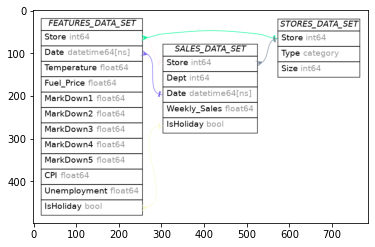

In [43]:
json_filename = 'ER_check8.json'
with open(json_filename, "w+") as f:
    f.write("{}".format(final_str))

# !erdot ER_check2.json
# !dot ER_check2.dot -Tpng -o imageFile2.png

# Calling ER Dot from Python
run_erdot = "erdot json_file".replace('json_file', json_filename)
# print(run_erdot)
erdot_output = os.popen(run_erdot).read()
sleep(0.2)
dot_filename = json_filename.replace('json','dot')
# print(dot_filename)
dot_filename = add_colors_to_dot_file(dot_filename)
sleep(0.2)
image_filename = 'ER_Diagram8.png'
print("ER Diagram saved at: '{}'".format(os.path.join(os.getcwd(),image_filename)))
run_dot = "dot dot_filename -Tpng -o image".replace('dot_filename',dot_filename)
run_dot = run_dot.replace('image',image_filename)
# print(run_dot)
dot_output = os.popen(run_dot).read()

# Display Generated ER Diagram  
# Read Images 
img = mpimg.imread(image_filename) 
# Output Images 
plt.imshow(img)
plt.show()

# Miscellaneous

In [52]:
import gc
gc.collect()

923

# ngrams Demo with Sample data

In [44]:
df1 = pd.DataFrame(data = [['ETX29300_PM3','XYZ','XYZ11']],columns = ['Machine','X1','X2'])
df2 = pd.DataFrame(data = [['ETX','PM3','29300','ABC1']],columns = ['Tool','Chamber','A1','A2'])
df3 = pd.DataFrame(data = [['ETX29300','PM3','AB','ABC1']],columns = ['Tool','Chamber','A1','A2'])

df1['inte'] = 1
df1['float'] = 2.0

results = []
all_comb = list(itertools.permutations(['df1','df2','df3'], 2))
ngrams_df1 = ngram_final(all_comb)

100%|██████████| 6/6 [00:00<00:00, 350.75it/s]


In [2]:
import os
os.getcwd()

'/home/longtailpdm/dimaag/Mahesh/Dash_Project'

In [45]:
ngrams_df1

,Table1,Table2,Table1_column,Table2_column,Criteria_Type,Criteria_Value
0,df1,df2,Machine,Tool,One2Many,0.956522
1,df1,df2,Machine,A1,One2Many,0.956522
2,df1,df2,Machine,Chamber,One2Many,0.956522
3,df1,df3,Machine,Tool,One2Many,0.956522
4,df1,df3,Machine,Chamber,One2Many,0.956522
5,df3,df2,Tool,Tool,One2Many,1.000000
6,df3,df2,Tool,A1,One2Many,1.000000


In [4]:
pip install py-dateinfer

SyntaxError: invalid syntax (<ipython-input-4-99fdc57baa42>, line 1)